In [236]:
import torch
from torch.distributions.multivariate_normal import MultivariateNormal
import math
from tqdm import tqdm

## Data Distributions

In [90]:
muX_0 = torch.ones(2)
muX_1 = -torch.ones(2)
CXX_0 = torch.eye(2)
CXX_1 = torch.eye(2)

def generate_distributions(a, b, a_, b_):
    
    muZ_0 =  torch.ones(2) * math.sqrt(a)
    muZ_1 = -torch.ones(2) * math.sqrt(b)

    CZZ_0 = a * torch.eye(2)
    CZX_0 = torch.eye(2) * math.sqrt(a_) 
    CZZ_1 = b * torch.eye(2)
    CZX_1 = torch.eye(2) * math.sqrt(b_)

    return  muZ_0,  muZ_1, CZZ_0, CZX_0, CZZ_1, CZX_1

## Utilities

In [198]:

def sample_Z_given(x, muZ_0, CZX_0, CZZ_0, CXZ_0, muZ_1, CZX_1, CZZ_1, CXZ_1, p, n_samples=10, seed=123):
    dist_0 = MultivariateNormal(loc=muZ_0 + CZX_0 @ torch.linalg.solve(CXX_0, x - muX_0), covariance_matrix=CZZ_0 - CZX_0 @ torch.linalg.solve(CXX_0, CXZ_0))
    dist_1 = MultivariateNormal(loc=muZ_1 + CZX_1 @ torch.linalg.solve(CXX_1, x - muX_1), covariance_matrix=CZZ_1 - CZX_1 @ torch.linalg.solve(CXX_1, CXZ_1))
    n1 = int(n_samples * p)
    n0 = n_samples - n1
    torch.manual_seed(seed)
    return torch.cat([dist_0.rsample((n0,)), dist_1.rsample((n1,))], dim=0)

def compute_lpxz(x, z, mvn_0, mvn_1, p):
    v = torch.cat([x, z], axis=1)
    lp_1 = math.log(p)
    lp_0 = math.log(1 - p)
    numer = mvn_1.log_prob(v) + lp_1
    denom = torch.logsumexp(torch.stack([mvn_1.log_prob(v) + lp_1, mvn_0.log_prob(v) + lp_0]), dim=0)

    return numer - denom

def compute_lpz(z, mvnZ_0, mvnZ_1, p):
    lp_1 = math.log(p)
    lp_0 = math.log(1 - p)
    numer = mvnZ_1.log_prob(z) + lp_1
    denom = torch.logsumexp(torch.stack([mvnZ_1.log_prob(z) + lp_1, mvnZ_0.log_prob(z) + lp_0]), dim=0)
    return numer - denom

def compute_lpx(x, mvnX_0, mvnX_1, p):
    lp_1 = math.log(p)
    lp_0 = math.log(1 - p)
    numer = mvnX_1.log_prob(x) + lp_1
    denom = torch.logsumexp(torch.stack([mvnX_1.log_prob(x) + lp_1, mvnX_0.log_prob(x) + lp_0]), dim=0)
    return numer - denom

def compute_cmi(mvn_0, mvn_1, mvnZ_0, mvnZ_1, n_samples, p, tol=1e-8, seed=123):

    # compute test data
    torch.manual_seed(seed)
    n1 = int(n_samples * p)
    n0 = n_samples - n1
    v = torch.cat([mvn_0.rsample((n0,)), mvn_1.rsample((n1,))], dim=0)
    x = v[:, :len(muX_0)]
    z = v[:, len(muX_0):]
    v_ = torch.cat([mvn_0.rsample((n0,)), mvn_1.rsample((n1,))], dim=0)
    z_ =  v_[:, len(muX_0):]

    # pxz = torch.clamp(compute_lpxz(x, z, mvn_0, mvn_1, p), min=tol, max=1 - tol)
    # pz = torch.clamp(compute_lpz(z_, mvnZ_0, mvnZ_1, p), min=tol, max=1 - tol)
    lpxz = compute_lpxz(x, z, mvn_0, mvn_1, p)
    lpz = compute_lpz(z_, mvnZ_0, mvnZ_1, p)
    pxz = torch.exp(lpxz)
    pz = torch.exp(lpz)

    # possible numerical issue from exp then log.
    H_XZ = (-(pxz) * lpxz - (1 - pxz) * torch.log1p(pxz)).mean()
    H_Z = (-(pz) * lpz - (1 - pz) * torch.log1p(pz)).mean()

    return H_Z - H_XZ

def compute_bayes_accuracy(p, x, y, mvnX_0, mvnX_1):
    lpx = compute_lpx(x, mvnX_0, mvnX_1, p)
    y_pred = (lpx >= math.log(0.5)).int()
    return (y == y_pred).sum() / len(y)

def compute_two_stage_accuracy(p, x, y, muZ_0, CZX_0, CZZ_0, CXZ_0, muZ_1, CZX_1, CZZ_1, CXZ_1, mvnZ_0, mvnZ_1, seed=123):
    px = []
    for x_ in x:
        z = sample_Z_given(x_, muZ_0, CZX_0, CZZ_0, CXZ_0, muZ_1, CZX_1, CZZ_1, CXZ_1, p, n_samples=1000, seed=seed)
        px.append(torch.exp(compute_lpz(z, mvnZ_0, mvnZ_1, p)).mean())
    px = torch.tensor(px)
    y_pred = (px >= 0.5).int()
    return (y == y_pred).sum() / len(y)

In [235]:
def run_experiment(p, a, b, a_, b_, n_samples=10, seed=123):

    # data distributions and parametrs
    muZ_0,  muZ_1, CZZ_0, CZX_0, CZZ_1, CZX_1 = generate_distributions(a, b, a_, b_)
    CXZ_0 = CZX_0.T
    CXZ_1 = CZX_1.T
    mu_0 = torch.cat([muX_0, muZ_0])
    mu_1 = torch.cat([muX_1, muZ_1])
    C_0 = torch.cat(
            [
                torch.cat([CXX_0, CXZ_0], dim=1),
                torch.cat([CZX_0, CZZ_0], dim=1)
            ], dim=0
        )
    C_1 = torch.cat(
        [
            torch.cat([CXX_1, CXZ_1], dim=1),
            torch.cat([CZX_1, CZZ_1], dim=1)
        ], dim=0
    )

    # samplers
    mvn_0 = MultivariateNormal(loc=mu_0, covariance_matrix=C_0)
    mvn_1 = MultivariateNormal(loc=mu_1, covariance_matrix=C_1)

    mvnX_0 = MultivariateNormal(loc=muX_0, covariance_matrix=CXX_0)
    mvnX_1 = MultivariateNormal(loc=muX_1, covariance_matrix=CXX_1)

    mvnZ_0 = MultivariateNormal(loc=muZ_0, covariance_matrix=CZZ_0)
    mvnZ_1 = MultivariateNormal(loc=muZ_1, covariance_matrix=CZZ_1)

    # test for conditional independence of X and Y given Z
    # muX_given_Z_0 = muX_0 - CXZ_0 @ torch.linalg.solve(CZZ_0, muZ_0)
    # muX_given_Z_1 = muX_1 - CXZ_1 @ torch.linalg.solve(CZZ_1, muZ_1)
    # print(torch.norm(muX_given_Z_0 - muX_given_Z_1))

    # CXX_given_Z_0 = CXX_0 - CXZ_0 @ torch.linalg.solve(CZZ_0, CZX_0)
    # CXX_given_Z_1 = CXX_1 - CXZ_1 @ torch.linalg.solve(CZZ_1, CZX_1)
    # print(torch.norm(CXX_given_Z_0 - CXX_given_Z_1))

    I = compute_cmi(mvn_0, mvn_1, mvnZ_0, mvnZ_1, n_samples, p)

    # compute test data
    torch.manual_seed(seed)
    n1 = int(n_samples * p)
    n0 = n_samples - n1
    x = torch.cat([mvnX_0.rsample((n0,)), mvnX_1.rsample((n1,))], dim=0)
    y = torch.cat([torch.zeros(n0), torch.ones(n1)]).int()

    acc1 = compute_bayes_accuracy(p, x, y, mvnX_0, mvnX_1)
    acc2 = compute_two_stage_accuracy(p, x, y, muZ_0, CZX_0, CZZ_0, CXZ_0, muZ_1, CZX_1, CZZ_1, CXZ_1, mvnZ_0, mvnZ_1)
    
    return I.item(), acc1.item(), acc2.item()

In [265]:
p = 0.5
a = 0.01
b = 0.01
props = torch.linspace(0.0, 0.9, 10)

Is, acc1s, acc2s = [], [], []
for prop in tqdm(props):
    a_ = prop * a
    b_ = prop * b
    I, acc1, acc2 = run_experiment(p, a, b, a_, b_, n_samples=1000, seed=123)
    Is.append(I)
    acc1s.append(acc1)
    acc2s.append(acc2)

100%|██████████| 10/10 [00:18<00:00,  1.85s/it]


In [266]:
torch.save(torch.tensor(Is), "output/mutual_info.pt")
torch.save(torch.tensor(acc1s), "output/bayes_accuracies.pt")
torch.save(torch.tensor(acc2s), "output/two_stage_accuracies.pt")

## Plotting

In [267]:
import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib as mpl

mpl.rcParams['lines.linewidth'] = 3
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16
mpl.rcParams["axes.labelsize"] = 23
mpl.rcParams['legend.fontsize'] = 20
mpl.rcParams['axes.titlesize'] = 28
# mpl.rcParams['text.usetex'] = True # comment out this line if the machine does not have TeX installed
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

In [268]:
Is = torch.load("output/mutual_info.pt")
acc1s = torch.load("output/bayes_accuracies.pt")
acc2s = torch.load("output/two_stage_accuracies.pt")

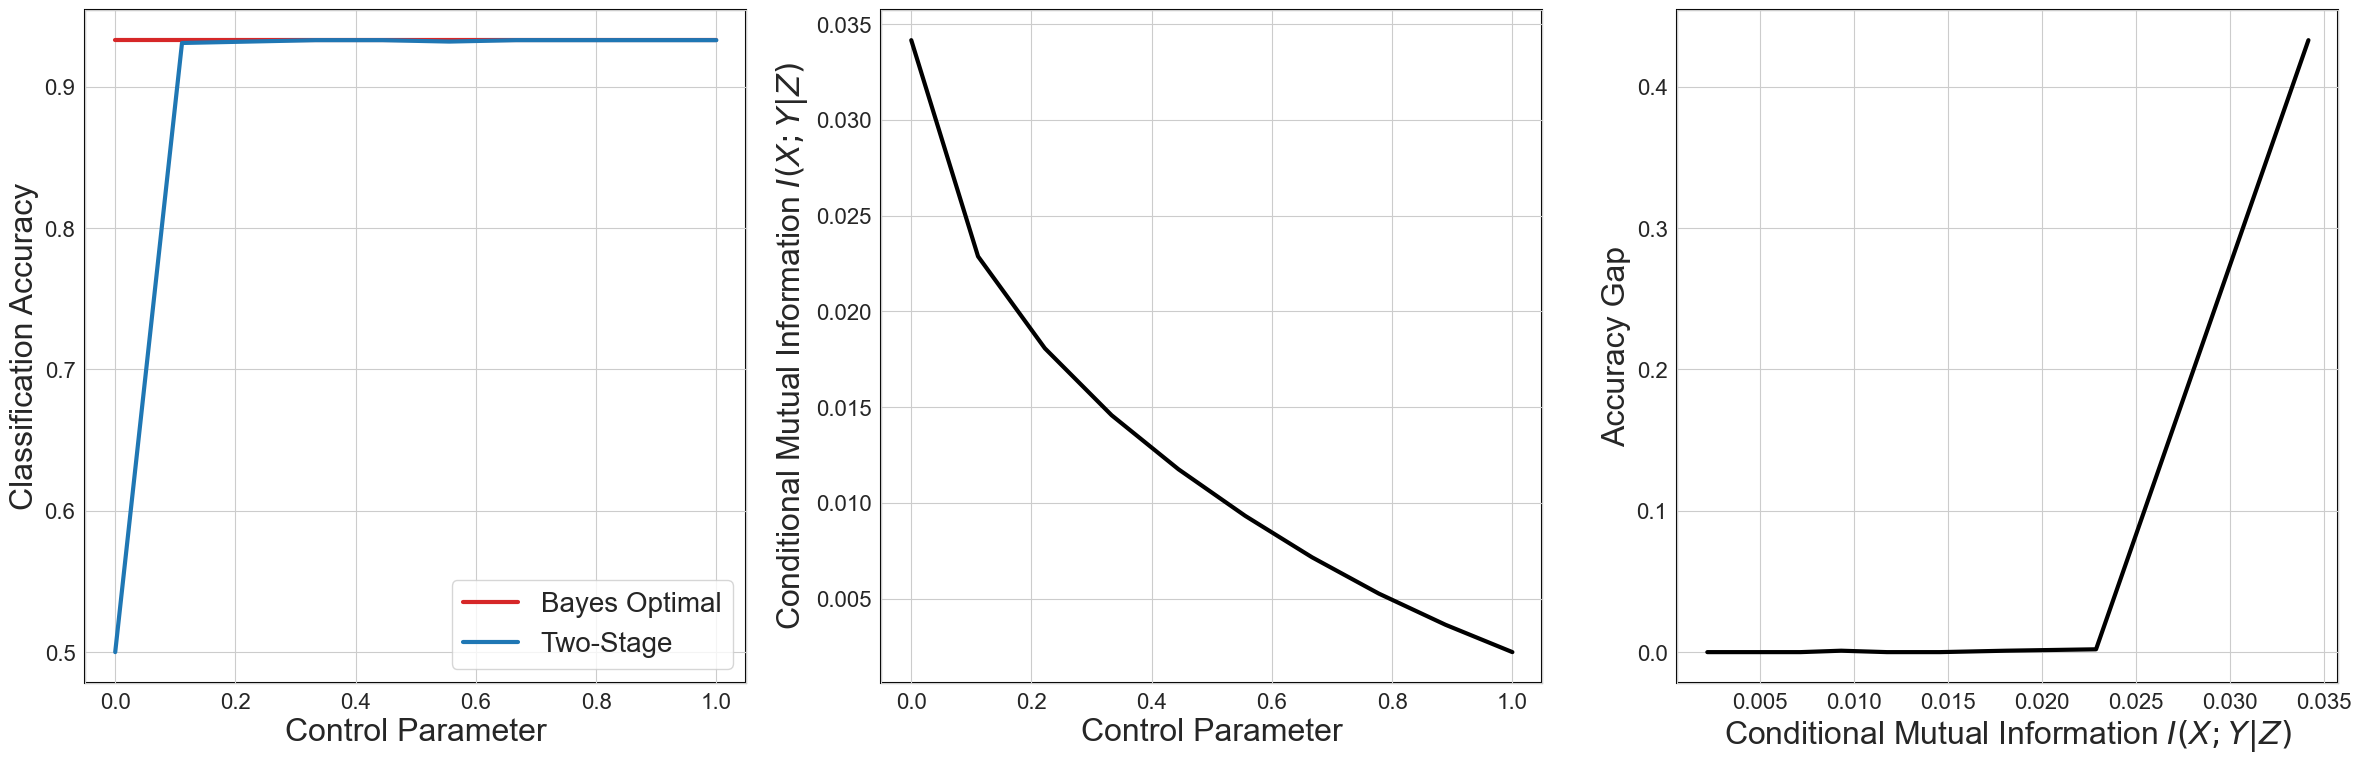

In [269]:
sns.set_style("whitegrid")

scale = 8
fig, ax = plt.subplots(1, 3, figsize=(3 * scale, scale))

points = torch.linspace(0.0, 1.0, len(Is))
ax[0].plot(points, acc1s, label="Bayes Optimal", color="tab:red")
ax[0].plot(points, acc2s, label="Two-Stage", color="tab:blue")
ax[0].legend(loc = "lower right")
ax[1].plot(points, Is, color="k")

ax[0].set_ylabel("Classification Accuracy")
ax[1].set_ylabel(r"Conditional Mutual Information $I(X;Y|Z)$")

ax[0].set_xlabel("Control Parameter")
ax[1].set_xlabel("Control Parameter")

ax[2].plot(Is, acc1s - acc2s, color="k")
ax[2].set_xlabel(r"Conditional Mutual Information $I(X;Y|Z)$")
ax[2].set_ylabel("Accuracy Gap")

for ax_ in ax:
    ax_.patch.set_edgecolor('black')  
    ax_.patch.set_linewidth(1.5)

fig.tight_layout(pad=2)

In [246]:
Is

tensor([0.0008, 0.0008, 0.0008, 0.0008, 0.0008, 0.0008, 0.0008, 0.0008, 0.0008,
        0.0008, 0.0008, 0.0008, 0.0008, 0.0008, 0.0008, 0.0008, 0.0008, 0.0008,
        0.0008, 0.0008])